In [4]:
# QuantConnect Imports
%load_ext autoreload
%autoreload 2

from clr import AddReference
AddReference("System")
AddReference('System.Memory')
AddReference("QuantConnect.Algorithm")
AddReference("QuantConnect.Api")
AddReference("QuantConnect.Common")
AddReference("QuantConnect.Configuration")
AddReference("QuantConnect.Research")
AddReference("QuantConnect.Indicators")

from System import *
from QuantConnect import *
from QuantConnect.Algorithm import * 
# instead use this AAPI 
# from QuantConnect.Api import * 
from quantconnect.api import Api
from QuantConnect.Configuration import *
from QuantConnect.Data import *
from QuantConnect.Data.Market import TradeBar, QuoteBar
from QuantConnect.Research import *
from QuantConnect.Indicators import *

import datetime 
import matplotlib.pyplot as plt
import pandas as pd

# PT imports 
import numpy as np 
import matplotlib.pylab as plt 
from my_utils import *  # my rolling window , mk_momentum , CrtpytoStream ... 
import scipy as sp 

# ipython debugger. set breakpoint with `dbg.set_trace()` 
import IPython.core.debugger as dbg

# execute this to connect to QuantConnect API 
api = Api(94240, "f9683aa5c308894f2238228a5f3545badd2e4b11526685cee58bb1cecf7e9f30")
# api.Initialize(
#     Config.GetInt("job-user-id",94240 ), 
#     Config.Get("api-access-token", "f9683aa5c308894f2238228a5f3545badd2e4b11526685cee58bb1cecf7e9f30"),
#     Config.Get("data-folder"))
# print(api.Connected)
print(api.connected())

# Create an quantBook instance
qb = QuantBook()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
True


In [ ]:
?

In [2]:
# Get the DATA
# load appl into the securities list and get the history of all the added securities 
apl = qb.AddEquity("AAPL")
ggl = qb.AddEquity("GOOGL")
# msft = qb.AddEquity('MSFT')

start_date = datetime.datetime(2011,1,1)
end_date = datetime.datetime(2012,1,1)

DIM = 21 
DIY = 12*DIM
LOOKBACK = 20*DIY # 20 years
history = qb.History(qb.Securities.Keys, LOOKBACK, Resolution.Daily)
print(qb.Securities.Keys)
history

[<QuantConnect.Symbol object at 0x7ffaf66a2208>, <QuantConnect.Symbol object at 0x7ffaf66a22e8>]


close         high          low  \
symbol            time                                                
AAPL R735QTJ8XC9X 2001-01-26     1.262899     1.306097     1.254641   
                  2001-01-27     1.238759     1.258452     1.210808   
                  2001-01-30     1.380423     1.381693     1.242571   
                  2001-01-31     1.380423     1.397575     1.326425   
                  2001-02-01     1.377882     1.453478     1.362000   
...                                   ...          ...          ...   
GOOG T1AZ164W5VTX 2021-02-02  1210.680000  1253.250000  1198.000000   
                  2021-02-03  1210.680000  1253.250000  1198.000000   
                  2021-02-04  1210.680000  1253.250000  1198.000000   
                  2021-02-05  1210.680000  1253.250000  1198.000000   
                  2021-02-06  1210.680000  1253.250000  1198.000000   

                                     open      volume  
symbol            time                                 
AAPL R735QTJ8XC9X 2001-01-26     1.306097   8337500.0  
                  2001-01-27     1.238759   8447800.0  
                  2001-01-30     1.242571  15160200.0  
                  2001-01-31     1.369623  12206500.0  
                  2001-02-01     1.365812  12279500.0  
...                                   ...         ...  
GOOG T1AZ164W5VTX 2021-02-02  1204.050000         0.0  
                  2021-02-03  1204.050000         0.0  
                  2021-02-04  1204.050000         0.0  
                  2021-02-05  1204.050000         0.0  
                  2021-02-06  1204.050000         0.0  

[9186 rows x 5 columns]

In [3]:
# filter between strat and end date 
times = history.index.get_level_values(1)
history = history.loc[(times <= end_date)  & (times > start_date)]
period = np.min(history.groupby(level="symbol").size())

# Computing the momentum 

using the `rolling_win` implementation, computing the momentum, defined by the formula: 

$$ \mu_t = \frac{p_{t-m}-p_{t-y}}{p_{t-y}},$$

is a simple as 
```py 
    rw = MyRollingWin(LOOKBACK)
    rw.batch_update(history)
    # compute the returns now with respect to DIY trading periods ago and shift DIM
    # days back to get the returns 1 month ago now
    momentum = rw.returns(DIY).groupby(level='symbol').shift(-DIM).dropna()
```


where $m$ is the number of trading days in a month (21) and $y$
is the number of trading days in a year ($12\times 21=252$). In
addition, the price changes over the last month can be taken 
into account to temper the expectations for future movement of an asset via the formula 

$$ \mu_t = \left( \frac{p_{t-m}-p_{t-y}}{p_{t-y}} - 
\frac{p_{t-1}-p_{t-m}}{p_{t-m}} \right )/\sigma_{r_t},$$

Notice here that we have normalized by the statistical
estimate of  the volatility in the returns of the asset 
in question, 
$\sigma_{r_t}$, in order to put less weight on highly volatile
securities.



In [93]:
rw = MyRollingWindow(history.groupby(level="symbol").size().min())
rw.batch_update(history)

period = 14
momentum = mk_momentum(rw,m = 0, n = period)
# take now the returns sigma over the same period  
sigma = mk_sigma(rw.data(), window = period)

# now normalize momentum by sigma 
alpha = momentum/sigma
alpha = alpha.dropna()
# make also the trendlines over a bit longer period to affirm a general trend 
trendlines = mk_trendlines(rw.data()['close'], 3*period)


In [94]:
# make also the trendlines over a bit longer period to affirm a general trend 
data = history

sma_srt = mk_SMA(data, 7).sort_index(ascending = False)
sma_lng = mk_SMA(data, 50).sort_index(ascending = False)

In [95]:
sym = apl.Symbol
df = history.xs(sym)

momentum = momentum.xs(sym)['close']
short = sma_srt.xs(sym)['close']
long  = sma_lng.xs(sym)['close']
alpha = alpha.xs(sym)['close']


crs_pts  = short[long.index] > long
crs_pts = crs_pts - crs_pts.shift(-1)
xs = crs_pts[np.abs(crs_pts) != 0]
print(xs)

def current_trend(df, period, date): 
    times = df.index
    df = df.loc[(times <= date)].sort_index(ascending = False)
    print(df)
    pks, _ = find_peaks(df.iloc[0:period])
    if len(pks) > 1: 
        begin, end = pks[0], pks[-1]
        return [df.index[begin], df.index[end], df.iloc[begin], df.iloc[end]]
    else: 
        return [df.index[0], df.index[period], df.iloc[0], df.iloc[period]]


time
2011-12-28      1
2011-12-14     -1
2011-12-13      1
2011-11-15     -1
2011-10-13      1
2011-10-07     -1
2011-07-07      1
2011-05-18     -1
2011-04-28      1
2011-04-06     -1
2011-04-01      1
2011-03-18     -1
2011-03-16    NaN
Name: close, dtype: object


In [96]:
trend = current_trend(df['close'], 30, xs.index[4])
idx = set(df.index).intersection(set(momentum.index)).intersection(set(short.index)).intersection( set(long.index)).intersection(set(alpha.index))

time
2011-10-13    51.088903
2011-10-12    50.855128
2011-10-11    49.399111
2011-10-08    46.985122
2011-10-07    47.938012
                ...    
2011-01-08    42.706008
2011-01-07    42.390919
2011-01-06    42.435388
2011-01-05    42.092347
2011-01-04    41.891605
Name: close, Length: 197, dtype: float64


In [97]:
momentum = momentum.loc[idx].sort_index()
short = short.loc[idx].sort_index()
long = long.loc[idx].sort_index()
df = df.loc[idx].sort_index()
alpha = alpha.loc[idx].sort_index()

In [98]:
Check this out for nice plot colors 

https://matplotlib.org/3.1.0/gallery/color/named_colors.html
    


SyntaxError: invalid syntax (<ipython-input-98-044c036f071f>, line 1)

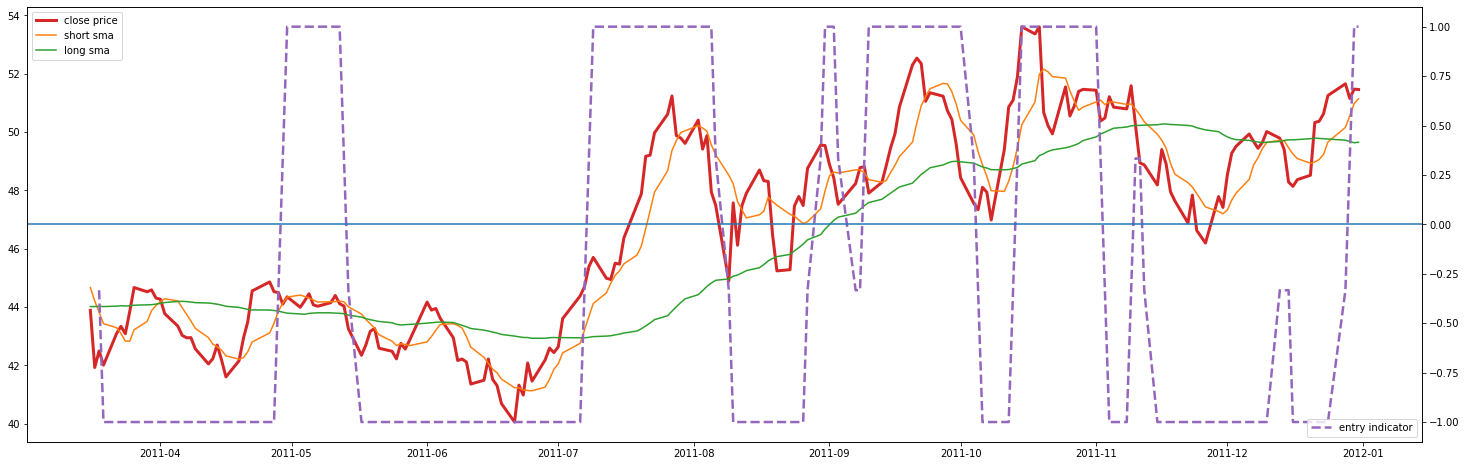

In [126]:
# # Strategy 1 Go long if 
# 1. Momentum normalized by volatility is positive 
# 2. current trend is positive (has positive slope) 
# 3. short sma is larger than long sma 

indicator = ((short > long) & (alpha > 0.0 ) ).apply(lambda x : 1.0 if x == True else -1)
make_entry = pd.Series(data = indicator)
make_entry = make_entry.rolling(3).mean()
fig,ax1 = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(25)
ax2=ax1.twinx()

ax1.plot(df['close'], 'C3', linewidth = 3 , label = "close price")
ax1.plot(short, 'C1', label = "short sma")
ax1.plot(long, 'C2', label = "long sma")
ax1.legend(loc = "upper left")

# l2. set
# for lines in trendlines[sym.Value]: 
#     df=  (lines[5] - lines[4])
#     dt = (lines[3] - lines[2]).days
#     slope =  df / dt # convert timdelta to days
#     ax1.plot(lines[2:4],lines[4:], linewidth= 7)
#     ax1.text(lines[2], lines[4], "{}-{}-days".format(slope,dt))

ax2.plot(make_entry,'--C4', linewidth = 2.5, label = "entry indicator")
# ax2.plot(alpha, "C5",  label = "alpha")

# # ax2.fill(positions.index, positions, "b", alpha = 0.2) 
# # ax2.bar(positions.index, 0.2*positions)
# # ax2.bar((momentum > 0.0).index,0.2)
# # ax2.plot(momentum_sma.xs(apl.Symbol)['close'], '-g')
plt.axhline(0.0)
ax2.legend(loc = "lower right")

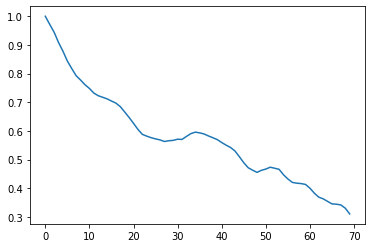

In [122]:
def acf(x, length=20):
    return np.array([1]+[np.corrcoef(x[:-i], x[i:])[0,1]  \
        for i in range(1, length)])

x = df['close']
res = acf(x, length = 70)
plt.plot(res)

In [120]:
?np.corrcoef

Signature: np.corrcoef(x, y=None, rowvar=True, bias=<no value>, ddof=<no value>)
Docstring:
Return Pearson product-moment correlation coefficients.

Please refer to the documentation for `cov` for more detail.  The
relationship between the correlation coefficient matrix, `R`, and the
covariance matrix, `C`, is

.. math:: R_{ij} = \frac{ C_{ij} } { \sqrt{ C_{ii} * C_{jj} } }

The values of `R` are between -1 and 1, inclusive.

Parameters
----------
x : array_like
    A 1-D or 2-D array containing multiple variables and observations.
    Each row of `x` represents a variable, and each column a single
    observation of all those variables. Also see `rowvar` below.
y : array_like, optional
    An additional set of variables and observations. `y` has the same
    shape as `x`.
rowvar : bool, optional
    If `rowvar` is True (default), then each row represents a
    variable, with observations in the columns. Otherwise, the relationship
    is transposed: each column represents a variable, 

2011-06-23   -1
2011-07-12   -1
2011-09-13   -1
2011-07-22   -1
2011-06-18   -1
             ..
2011-11-16   -1
2011-06-07   -1
2011-06-10    1
2011-08-04    1
2011-09-28    1
Length: 203, dtype: int64

KeyError: 'GOOG T1AZ164W5VTX'

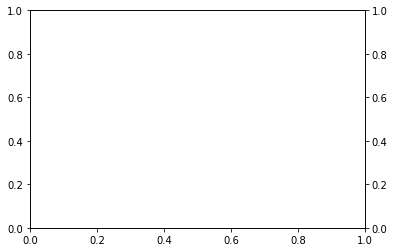

In [38]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
ax2=ax.twinx()
ax.plot(momentum.xs(ggl.Symbol)['close'])
ax2.plot(sigma.xs(ggl.Symbol)['close'], '-r')
ax2.plot(sigma_sma.xs(ggl.Symbol)['close'], '--g')
ax2.plot(sigma_ema.xs(ggl.Symbol)['close'], '--b')
ax2.set_ylabel("sigma from {} ticks".format(winsize))

pandas.core.series.Series

In [18]:
ggl_df = history.xs(ggl.Symbol)

for tpl in ggl_df.itertuples():
#     tpl.

SyntaxError: unexpected EOF while parsing (<ipython-input-18-750e49359329>, line 4)